<a href="https://colab.research.google.com/github/KayKozaronek/03_Courses/blob/master/S%2BP_Week_2_Lesson_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis with a Deep Neural Network and Callbacks

In [0]:
# imports 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [0]:
# Define plot_series funciton
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
# Define Trend function
def trend(time, slope=0):
  return time*slope

In [0]:
# Define seasonal_pattern function
def seasonal_pattern(season_time):
  """ You can edit this function to your liking \n
  This will be input for our seasonality function"""
  return np.where(season_time< 0.4,
                  np.cos(season_time * 2 *np.pi),
                  1/ np.exp(3*season_time))

In [0]:
# Define seasonality function
def seasonality(time, period, amplitude=1, phase =0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

In [0]:
# Define Noise
def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [0]:
# Define parameters 
time = np.arange(4*365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 20
noise_level = 5
slope = 0.09

In [0]:
# Create the series 
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Add noise 
series += noise(time, noise_level, seed=42)

In [0]:
# Create Training set
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

# Create Test set 
time_valid = time[split_time:]
x_valid = series[split_time:]

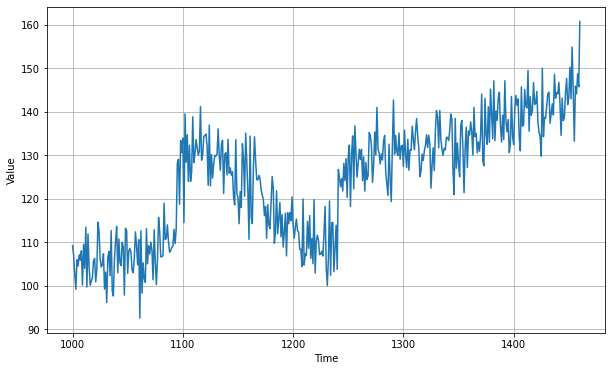

In [88]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)

In [0]:
# Define Hyperparameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
# Define windowed_dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(size = window_size +1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
# Create dataset
dataset = windowed_dataset(x_train, 
                           window_size, 
                           batch_size, 
                           shuffle_buffer_size)

In [93]:
# Define, compile and fit model (3 Dense layers)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape = [window_size], activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum =0.9),
              loss = "mse")

model.fit(dataset, 
          epochs = 100,
          verbose= 1)

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 966.3639
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 70.0921
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 49.5477
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 48.5991
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 48.4966
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 48.4426
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 48.4247
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 48.3472
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 48.3407
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 48.2166
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 48.1278
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 48.0792
Epoch 13/100
31/31 [====

In [0]:
# Create a forecast
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

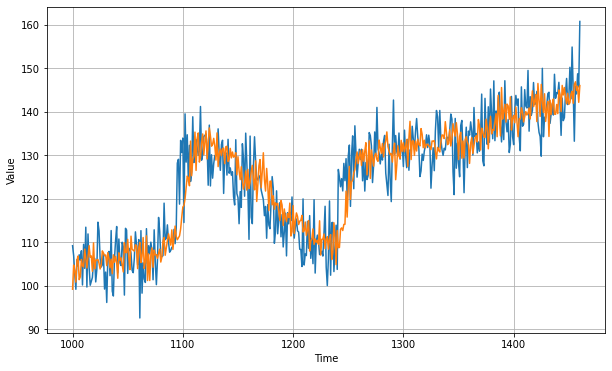

In [96]:
# Plot Results against validation data
plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [98]:
# Calculate MAE 
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0653358

In [0]:
# Create a dataset, lr_schedule, compile and fit the model
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, input_shape=[window_size], activation = "relu"),
        tf.keras.layers.Dense(10, activation = "relu"),
        tf.keras.layers.Dense(1)
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)

model.compile(loss = "mse",
              optimizer =optimizer)

history = model.fit(dataset, epochs =100,
                    callbacks = [lr_schedule], 
                    verbose =0)

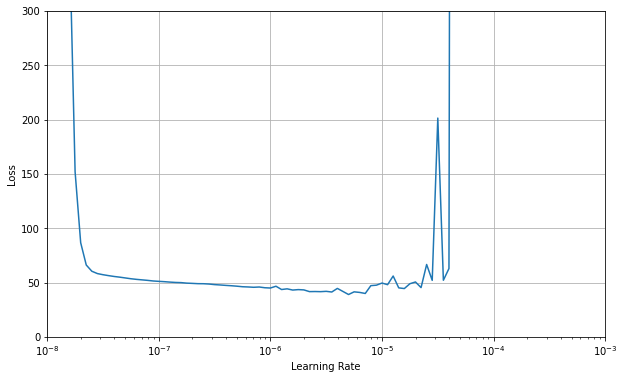

In [103]:
# Plot the learning rate 
plt.figure(figsize =(10,6))
lrs = 1e-8 * (10**(np.arange(100)/20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.grid(True)

In [109]:
# Define Model again with adjusted Learning Rate and new window_size
#window_size = 30 
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size],activation="relu"),
    tf.keras.layers.Dense(10, activation ="relu"),
    tf.keras.layers.Dense(1)
])
print(model.summary())

model.compile(loss = "mse",
              optimizer = tf.keras.optimizers.SGD(lr = 5e-6, momentum =0.9))
history = model.fit(dataset, epochs = 500, verbose =0)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_22 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
None


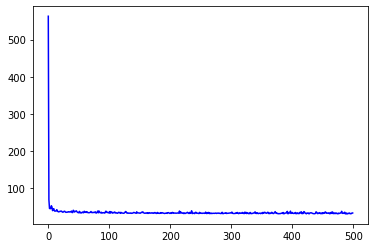

In [110]:
# Plot results
loss = history.history["loss"]
epochs = range(len(loss))
plt.plot(epochs, loss, "b", label="Training Loss")
plt.show()

[38.85309600830078, 37.78721237182617, 38.29867172241211, 38.82978057861328, 41.87813949584961, 37.35603332519531, 36.87863540649414, 35.932491302490234, 37.12302780151367, 36.75255584716797, 37.69246292114258, 38.169864654541016, 37.4349250793457, 35.30818176269531, 35.249267578125, 35.831398010253906, 37.63658905029297, 37.56243896484375, 35.632694244384766, 34.65594482421875, 35.17255401611328, 35.002342224121094, 35.62350082397461, 36.47084426879883, 35.526763916015625, 36.07408142089844, 35.480350494384766, 36.54860305786133, 38.07893371582031, 34.31478500366211, 34.201499938964844, 40.242515563964844, 38.1978759765625, 35.48265838623047, 37.45418167114258, 37.329811096191406, 38.72122573852539, 36.28501510620117, 34.54658126831055, 34.044212341308594, 33.52176284790039, 37.215728759765625, 33.464839935302734, 34.550777435302734, 33.298980712890625, 33.207122802734375, 35.575599670410156, 34.386775970458984, 33.536251068115234, 37.57065200805664, 34.977577209472656, 35.43662643432

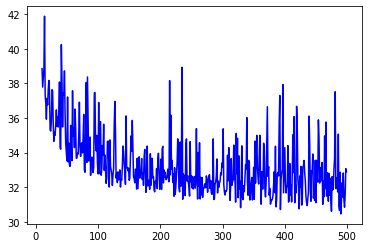

In [111]:
# Plot all but the first 10 
loss = history.history["loss"]
epochs = range(10,len(loss))
plot_loss = loss[10:]
print(plot_loss)

plt.plot(epochs, plot_loss, "b", label ="Training Loss")
plt.show()

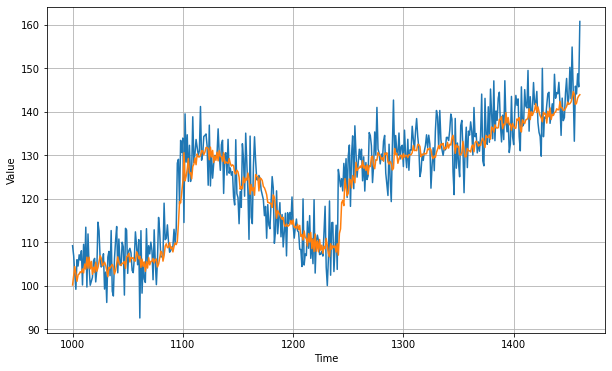

In [112]:
# Create another forecast
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [113]:
# Compute MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.510549

# Open Questions:

- What is np.newaxis? 

- why do we add the window_size and later substract it when we add values to our forecast?
